In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [3]:
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# train collection
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation collection
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
batch_size = 32
img_height = 64
img_width = 64

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=32
)

validation_ds = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(64, 64),
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

In [7]:
# shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [8]:
# buffered prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = 2

data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal",
        input_shape=(img_height, img_width,3)
    ),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = keras.models.Sequential([
    data_augmentation,
    # 归一化
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    # 卷积层1
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(2, 2),

    # 卷积层2
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(2, 2),

    # 卷积层3
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(2, 2),

    # dropout
    keras.layers.Dropout(0.2),

    # 拉平
    keras.layers.Flatten(),

    # dense层
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes),
])

In [10]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['acc'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

In [12]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
)

Epoch 1/20
63/63 [==============================] - 12s 138ms/step - loss: 0.7784 - acc: 0.5015 - val_loss: 0.6919 - val_acc: 0.6040
Epoch 2/20
63/63 [==============================] - 7s 116ms/step - loss: 0.6925 - acc: 0.5346 - val_loss: 0.7256 - val_acc: 0.5000
Epoch 3/20
63/63 [==============================] - 7s 112ms/step - loss: 0.6973 - acc: 0.5261 - val_loss: 0.6827 - val_acc: 0.5370
Epoch 4/20
63/63 [==============================] - 7s 110ms/step - loss: 0.6878 - acc: 0.5474 - val_loss: 0.6631 - val_acc: 0.5970
Epoch 5/20
63/63 [==============================] - 7s 112ms/step - loss: 0.6697 - acc: 0.5962 - val_loss: 0.6390 - val_acc: 0.6470
Epoch 6/20
63/63 [==============================] - 7s 112ms/step - loss: 0.6387 - acc: 0.6601 - val_loss: 0.6499 - val_acc: 0.6060
Epoch 7/20
63/63 [==============================] - 7s 114ms/step - loss: 0.6179 - acc: 0.6676 - val_loss: 0.6380 - val_acc: 0.6300
Epoch 8/20
63/63 [==============================] - 7s 115ms/step - loss: 0

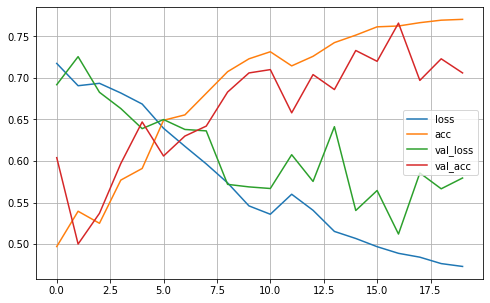

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True)

In [31]:
# predict
cat_test_path = './test/cat/cat_test.JPG'
img = keras.preprocessing.image.load_img(
    cat_test_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score)} percent confidence."

'This image most likely belongs to cats with a 55.96993565559387 percent confidence.'